In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 as cv

from os.path import join

plt.rcParams['figure.figsize'] = [8, 8]
# fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

### Pre-Processing

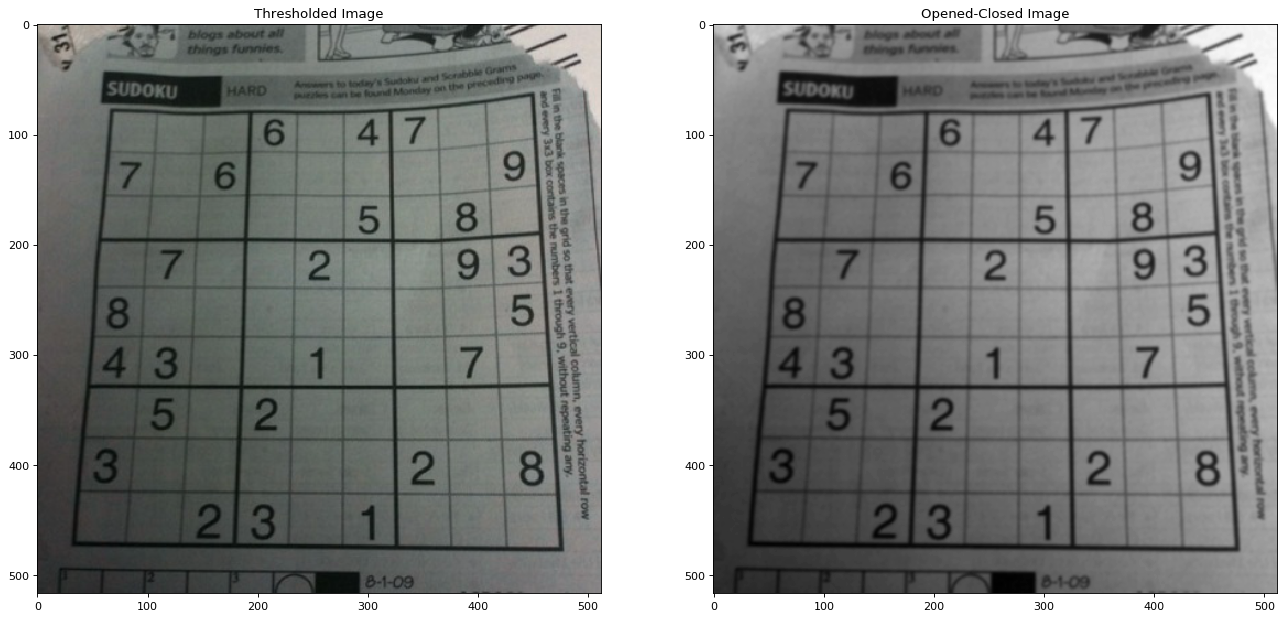

In [182]:
#Pre-processing
imgpath = "./test_imgs/";
img = cv.imread(join(imgpath, "sudoku4.jpg"));

#Resize image such that minimum of its dimension = 512
rows,cols,ch = img.shape
k = 512/min(rows, cols)
img = cv.resize(img, (0,0), fx=k, fy=k)
rows,cols,ch = img.shape

#Convert to grayscale
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY);
dim = 5

#Smoothing to remove any extra noise
img_gray = cv.GaussianBlur(img_gray,(dim,dim),0)
# img_gray = cv.medianBlur(img_gray, dim)

fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(img); plt.title('Thresholded Image')
plt.subplot(122); plt.imshow(img_gray, 'gray'); plt.title('Opened-Closed Image')
plt.show()

### Adaptive Thresholding (Binarizing the Image)

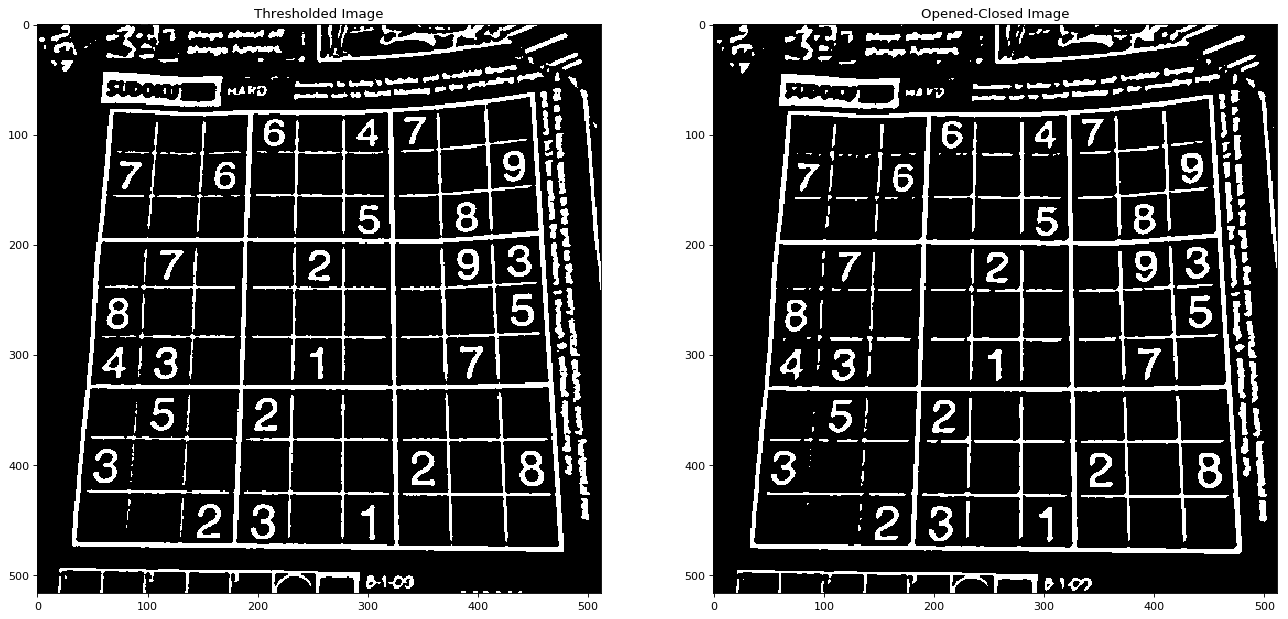

In [183]:
#Adaptive Thresholding
thresh = cv.adaptiveThreshold(img_gray, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY_INV, 21, 7);

#Noise Removal (Morphological Opening)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(2,2));
img_bw = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel);
img_bw = cv.morphologyEx(img_bw, cv.MORPH_CLOSE, kernel);

fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(thresh, 'gray'); plt.title('Thresholded Image')
plt.subplot(122); plt.imshow(img_bw, 'gray'); plt.title('Opened-Closed Image')
plt.show()

### Extracting the Grid (Largest Connected Component)

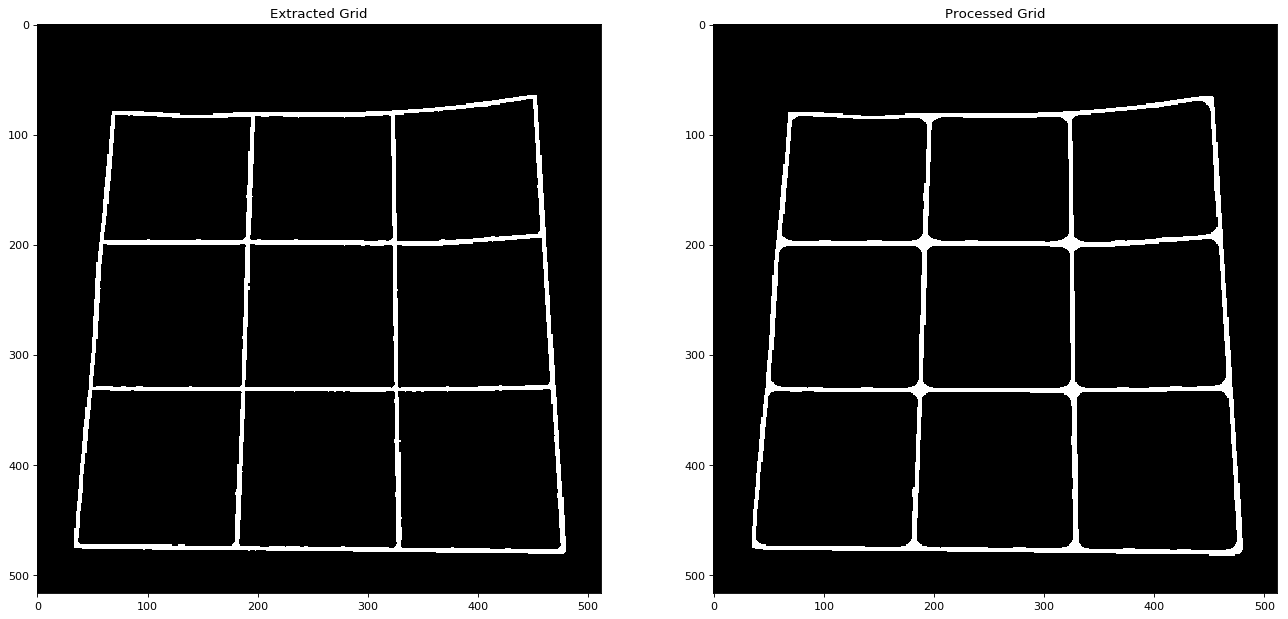

In [184]:
#Largest Connected Component
def largest_CC (image):
    image = image.astype('uint8')
    nb_components, output, stats, centroids = cv.connectedComponentsWithStats(image, connectivity=8)
    sizes = stats[:, -1]
    
    max_size = 0 
    img2 = np.zeros((1,1))
    if len(sizes)>1:
        max_label = 1
        max_size = sizes[1]
        for i in range(2, nb_components):
            if sizes[i] > max_size:
                max_label = i
                max_size = sizes[i]

        img2 = np.zeros(output.shape)
        img2[output == max_label] = 255

    return img2, max_size

#Extract the outer grid
grid, s = largest_CC(img_bw)
grid = grid.astype(np.uint8)

#Morphological Closing (Strengthens the grid)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(20,20));
proc_grid = cv.morphologyEx(grid, cv.MORPH_CLOSE, kernel);

# Display Grid
fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(grid, 'gray'); plt.title('Extracted Grid')
plt.subplot(122); plt.imshow(proc_grid, 'gray'); plt.title('Processed Grid')
plt.show()

### Helper Functions

In [185]:
##Helper Functions 1 (Extracting the lines)
def takeFirst(elem):
    return abs(elem[0])

def overlayLines(overlay, lines):
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array 
    for line in lines:
        r = line[0]
        theta = line[1]

        # Stores the value of cos(theta) in a 
        a = np.cos(theta) 

        # Stores the value of sin(theta) in b 
        b = np.sin(theta) 

        # x0 stores the value rcos(theta) 
        x0 = a*r 

        # y0 stores the value rsin(theta) 
        y0 = b*r 

        # x1 stores the rounded off value of (rcos(theta)-1000sin(theta)) 
        x1 = int(x0 + 3000*(-b)) 

        # y1 stores the rounded off value of (rsin(theta)+1000cos(theta)) 
        y1 = int(y0 + 3000*(a)) 

        # x2 stores the rounded off value of (rcos(theta)+1000sin(theta)) 
        x2 = int(x0 - 3000*(-b)) 

        # y2 stores the rounded off value of (rsin(theta)-1000cos(theta)) 
        y2 = int(y0 - 3000*(a)) 

        # draw a line in img from the point(x1,y1) to (x2,y2).
        cv.line(overlay,(x1,y1),(x2,y2),(0,0,255),2)

################################################ TODO ###################################################
##Helper Functions 2 (Segregation and grouping of lines)
def segregateBoundLines(lines):
    hl = [lines[0]]
    vl = [lines[1]]
    theta_diff = abs(lines[0][1]-lines[2][1])
    
    #Seperate the parallel lines
    if theta_diff < 0.1 or theta_diff > 2.9:
        hmax = 2
        vmax = 3
    else:
        hmax = 3
        vmax = 2

    hl += [lines[hmax]]
    vl += [lines[vmax]]

    # Swap if assigned wrongly
    if min(hl[1][1], 3.14-hl[1][1]) > min(vl[1][1], 3.14-vl[1][1]):
        temp = vl
        vl = hl
        hl = temp
    
    return hl,vl

# https://stackoverflow.com/a/383527/5087436
def intersectionPoints(line1, line2):
    """Finds the intersection of two lines given in Hesse normal form.
    Returns closest integer pixel locations.
    """
    rho1, theta1 = line1
    rho2, theta2 = line2
    A = np.array([
        [np.cos(theta1), np.sin(theta1)],
        [np.cos(theta2), np.sin(theta2)]
    ])
    b = np.array([[rho1], [rho2]])
    x0, y0 = np.linalg.solve(A, b)
    x0, y0 = int(np.round(x0)), int(np.round(y0))
    return [x0, y0] 

### Extract Boundary lines (Hough Transform)

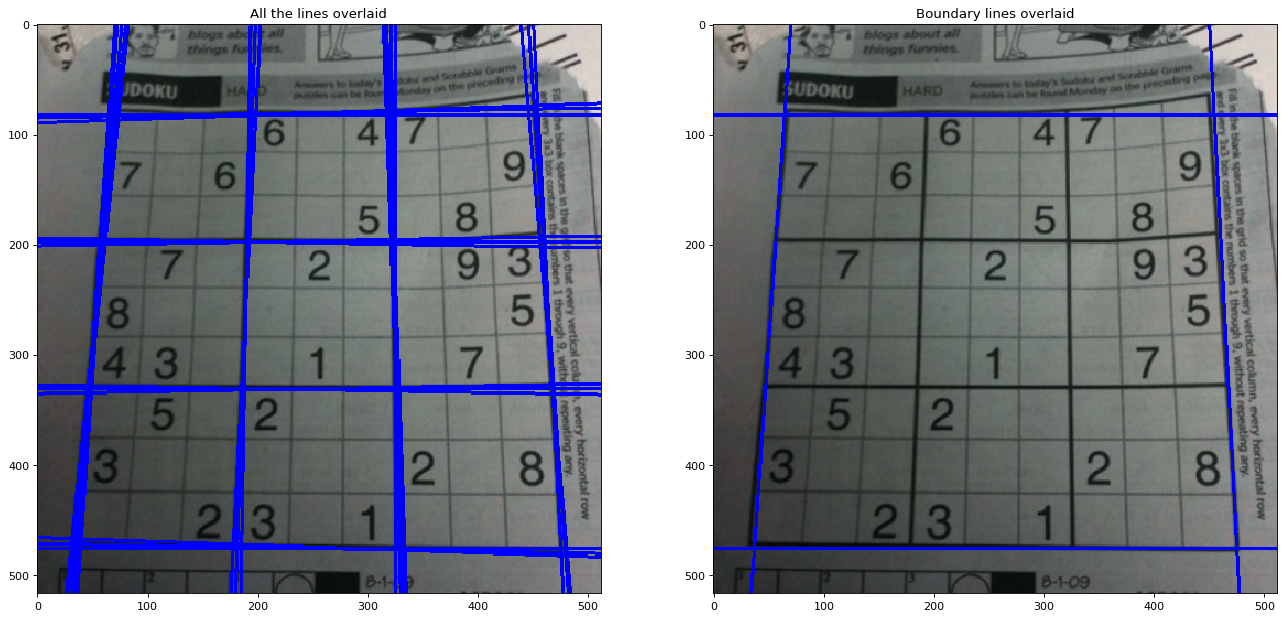

[(70.0, 0.06981317), (83.0, 1.5707964), (476.0, 1.5707964), (-450.0, 3.0892327)]


In [186]:
proc_grid = proc_grid.astype(np.uint8)

# This returns an array of r and theta values 
lines = cv.HoughLines(grid, 1, np.pi/180, 200)

sortedlines = []
for line in lines:
    for rho,theta in line:
        sortedlines+=[(rho, theta)]

# sort list with key
sortedlines.sort(key=takeFirst)

#Seperate the boundary lines
res = 0.3      #Resolution for theta

#First Minimum
first_min = sortedlines[0]
    
#Seconod Minimum
for i in range(1,len(sortedlines)):
    l = sortedlines[i]
    if (l[1] >= first_min[1] + res) or (l[1] <= first_min[1] - res):
            second_min = l
            break

#First Maximum
first_max = sortedlines[-1]

#Second Maximum
for i in range(len(sortedlines)-2, 0, -1):
    l = sortedlines[i]
    if (l[1] >= first_max[1] + res) or (l[1] <= first_max[1] - res):
            second_max = l
            break

#Boundary lines
boundaries = [first_min, second_min, first_max, second_max]

# Overlaying all the edges
overlayAll = img.copy()
overlayBound = img.copy()

overlayLines(overlayAll, sortedlines)
overlayLines(overlayBound, boundaries)

#Display the result
fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(overlayAll, 'gray'); plt.title('All the lines overlaid')
plt.subplot(122); plt.imshow(overlayBound, 'gray'); plt.title('Boundary lines overlaid')
plt.show()

# print(sortedlines)
print(boundaries)

### Group parallel lines

In [187]:
#Segregate all the Boundary Lines into Horizontal and Vertical (Relatively)
hor_lines, vert_lines = segregateBoundLines(boundaries)
print(hor_lines)
print(vert_lines)

#Intersection points
pts1 = []
pts1 += [intersectionPoints(hor_lines[0], vert_lines[0])]
pts1 += [intersectionPoints(hor_lines[1], vert_lines[0])]
pts1 += [intersectionPoints(hor_lines[0], vert_lines[1])]
pts1 += [intersectionPoints(hor_lines[1], vert_lines[1])]
pts1 = np.float32(np.array(pts1))

#Desired points
pts2 = np.float32([[0,0], [rows,0], [0,cols], [rows,cols]])

print(pts1)
print(pts2)

[(70.0, 0.06981317), (-450.0, 3.0892327)]
[(83.0, 1.5707964), (476.0, 1.5707964)]
[[ 64.  83.]
 [455.  83.]
 [ 37. 476.]
 [476. 476.]]
[[  0.   0.]
 [517.   0.]
 [  0. 512.]
 [517. 512.]]


### Unwarping the Image

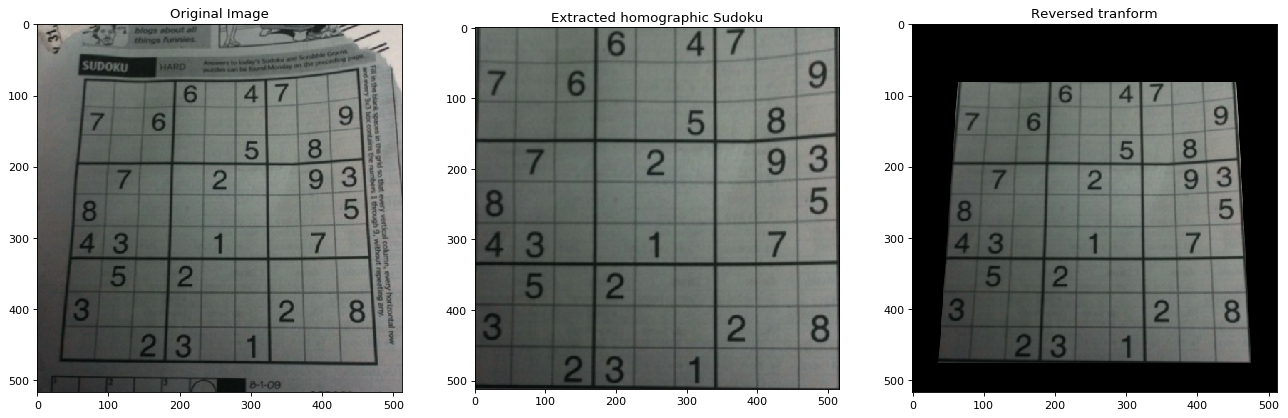

In [188]:
#Get the affine transform from the pts
forward = cv.getPerspectiveTransform(pts1,pts2)
backward = cv.getPerspectiveTransform(pts2,pts1)

#Apply the transform
sudoku = cv.warpPerspective(img, forward, (rows,cols))

#Reverse Transform
r,c,ch = sudoku.shape
trial = cv.warpPerspective(sudoku, backward, (r,c))

fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131); plt.imshow(img, 'gray'); plt.title('Original Image')
plt.subplot(132); plt.imshow(sudoku, 'gray'); plt.title('Extracted homographic Sudoku')
plt.subplot(133); plt.imshow(trial, 'gray'); plt.title('Reversed tranform')
plt.show()

### Processing the Homographic Outer Grid

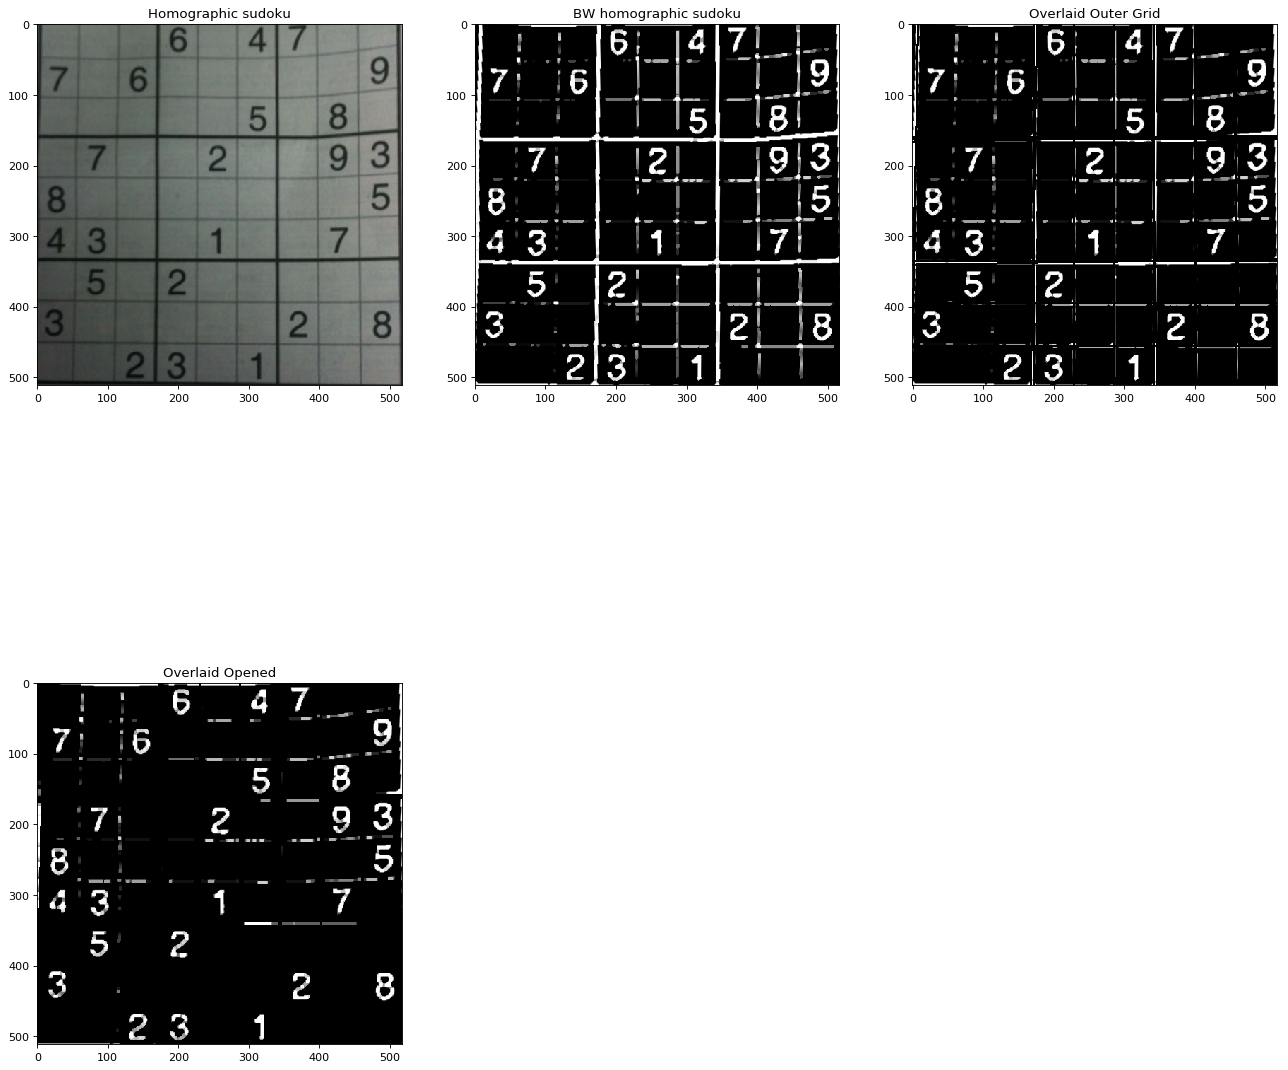

In [189]:
########################################### TODO #########################################
#Apply forward transform to BW image
sudoku_bw = cv.warpPerspective(img_bw, forward, (rows,cols))
# sudoku_bw = cv.cvtColor(sudoku, cv.COLOR_BGR2GRAY)

#Morph opening to remove noise
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(4,4))
sudoku_bw = cv.morphologyEx(sudoku_bw, cv.MORPH_OPEN, kernel)

# This returns an array of r and theta values 
lines = cv.HoughLines(sudoku_bw, 1, np.pi/180, 400)

sortedlines = []
for line in lines:
    for rho,theta in line:
        sortedlines+=[(rho, theta)]

#Overlaying the lines (Removes majority of the lines)
overlay = sudoku_bw.copy()
overlayLines(overlay, sortedlines)

#Morphological Opening
kernel = cv.getStructuringElement(cv.MORPH_RECT,(4,4));
overlay_opened = cv.morphologyEx(overlay, cv.MORPH_OPEN, kernel);

#Thresholding
# thresh = 250
# overlay_opened_thresh = overlay_opened>thresh

fig=plt.figure(figsize=(20, 20), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(231); plt.imshow(sudoku, 'gray'); plt.title('Homographic sudoku')
plt.subplot(232); plt.imshow(sudoku_bw, 'gray'); plt.title('BW homographic sudoku')
plt.subplot(233); plt.imshow(overlay, 'gray'); plt.title('Overlaid Outer Grid')
plt.subplot(234); plt.imshow(overlay_opened, 'gray'); plt.title('Overlaid Opened')
# plt.subplot(235); plt.imshow(overlay_opened_thresh, 'gray'); plt.title('Overlaid Opened Thresh')
plt.show()

### Train a Classifier 1: Neural Network

In [114]:
################################################### TODO ######################################
#Train NN on MNIST
mnist = tf.keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=30, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(filters=15, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
60000/60000 [==============================] - 45s 748us/step - loss: 0.2454 - acc: 0.9234
Epoch 2/5
60000/60000 [==============================] - 47s 779us/step - loss: 0.0913 - acc: 0.9715
Epoch 3/5
60000/60000 [==============================] - 44s 726us/step - loss: 0.0668 - acc: 0.9783
Epoch 4/5
60000/60000 [==============================] - 47s 783us/step - loss: 0.0533 - acc: 0.9835
Epoch 5/5
10000/10000 [==============================] - 3s 347us/step


[0.039232961459795476, 0.9875]

In [ ]:
############# Save model##############

### Train a Classifier 2: Linear SVM

In [14]:
# Import the modules
from sklearn.externals import joblib
from sklearn import datasets
from skimage.feature import hog
from sklearn.svm import LinearSVC
from collections import Counter

# Load the dataset
dataset = datasets.fetch_mldata("MNIST Original")

# Extract the features and labels
features = np.array(dataset.data, 'int16') 
labels = np.array(dataset.target, 'int')

# Extract the hog features
list_hog_fd = []
for feature in features:
    fd = hog(feature.reshape((28, 28)), orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
    list_hog_fd.append(fd)
hog_features = np.array(list_hog_fd, 'float64')

print("Count of digits in dataset", Counter(labels))

# Create an linear SVM object
clf = LinearSVC()

# Perform the training
clf.fit(hog_features, labels)

# Save the classifier
joblib.dump(clf, "digits_cls.pkl", compress=3)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


Count of digits in dataset Counter({1: 7877, 7: 7293, 3: 7141, 2: 6990, 9: 6958, 0: 6903, 6: 6876, 8: 6825, 4: 6824, 5: 6313})


['digits_cls.pkl']

### Digit Classification

In [190]:
#Helper Functions
def display_matrix(grid):
    for i in range(9):
        string = ""
        for j in range(9):
            string += str(grid[i][j]) + " "
        print(string)

def is_empty(block):
    lcc, size = largest_CC(block)
    m,n = block.shape
    ratio = size/(m*n)
    if ratio < 0.1:
        ################################### TODO ###############################
        return True
    return False

def extract_digit(im):
    # Find contours in the image
    im = im.astype(np.uint8)
    block = im.copy()
    r,c = block.shape
    im = np.concatenate([np.expand_dims(block, axis=2)]*3, axis=2)
    print(im.shape)
    
    ctrs, hier, _ = cv.findContours(block, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Get rectangles contains each contour
    rects = [cv.boundingRect(ctr) for ctr in ctrs]
    rect = rects[0]
    
    # Marking the rectangular region around the image
    cv.rectangle(im, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3) 
    
    # Make the rectangular region around the digit
    leng = int(rect[3] * 1.6)
    pt1 = int(rect[1] + rect[3] // 2 - leng // 2)
    pt2 = int(rect[0] + rect[2] // 2 - leng // 2)
    roi = block[pt1:pt1+leng, pt2:pt2+leng]
    
    # Resize the image
#     roi = cv.resize(roi, (28, 28), interpolation=cv.INTER_AREA)
    print(roi.shape)
    roi = cv.resize(roi, (28, 28))
    roi = cv.dilate(roi, (3, 3))
    
    return roi, im



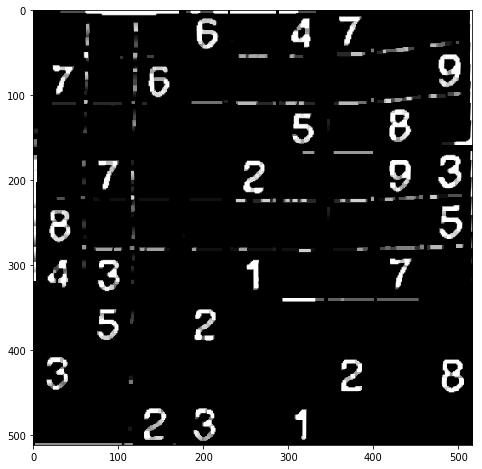

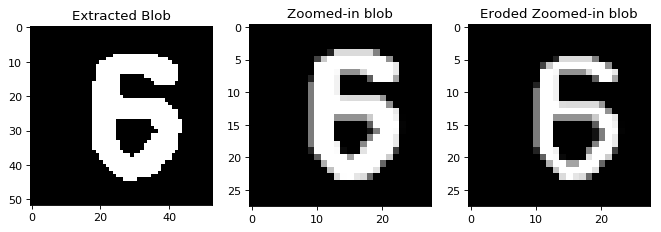

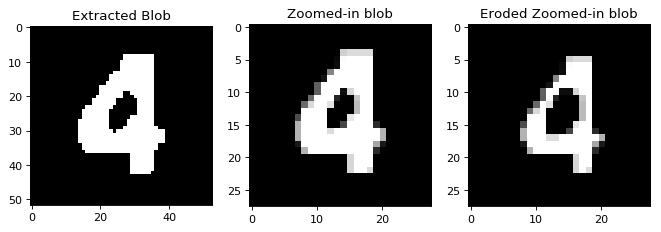

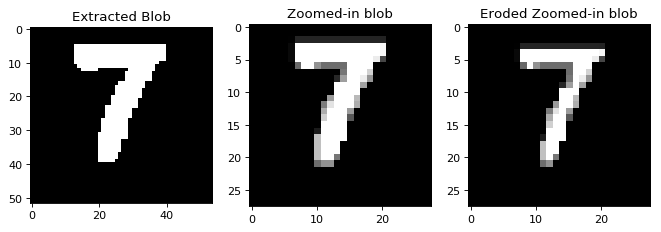

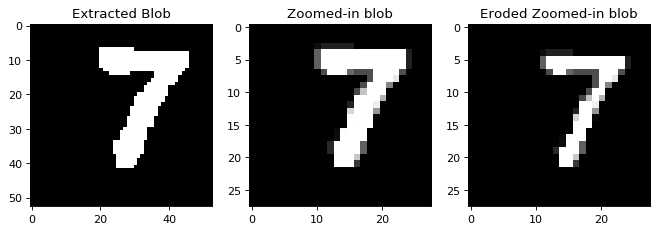

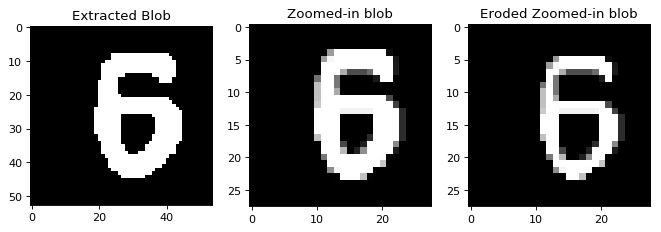

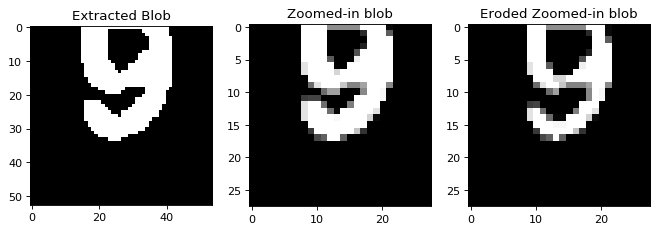

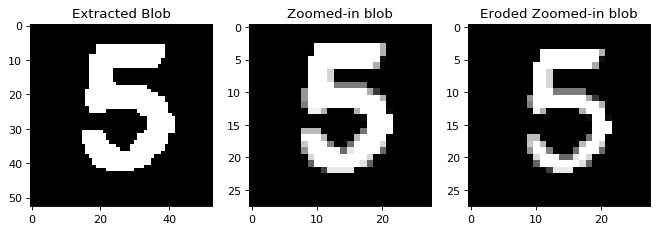

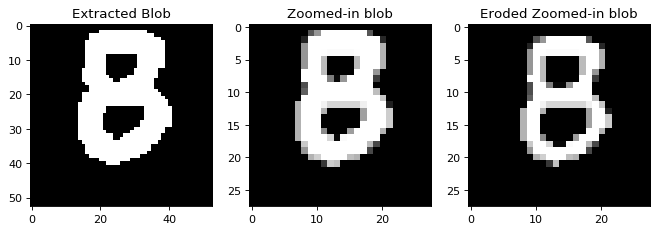

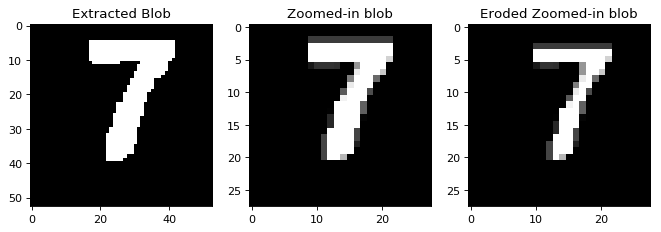

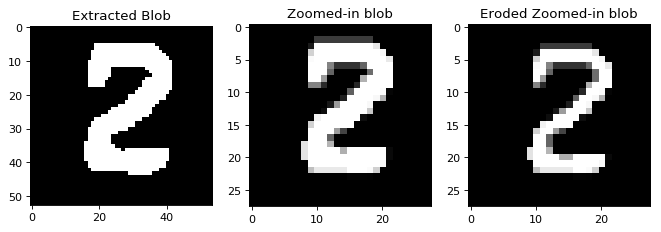

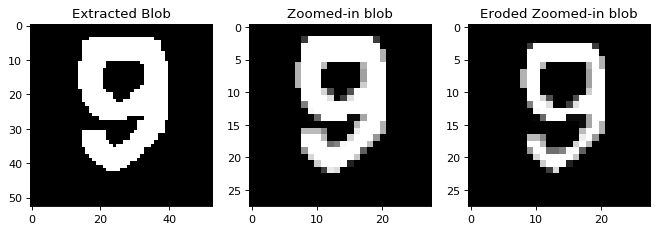

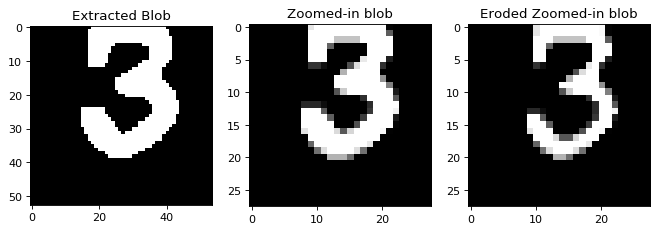

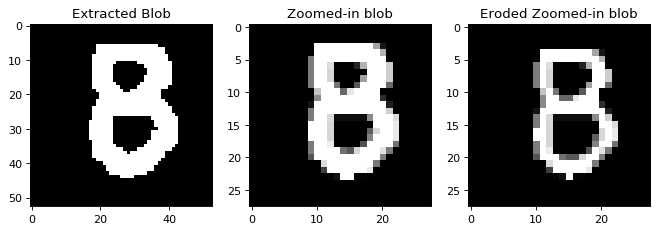

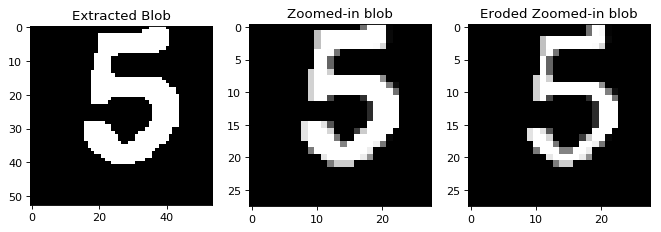

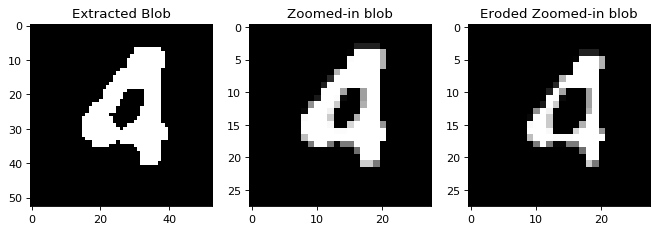

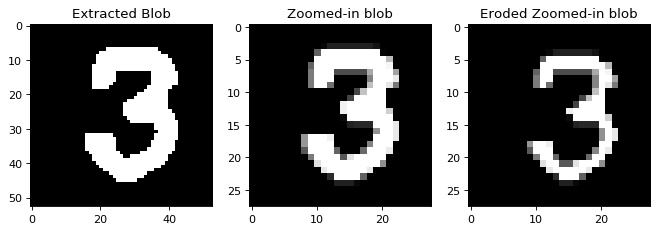

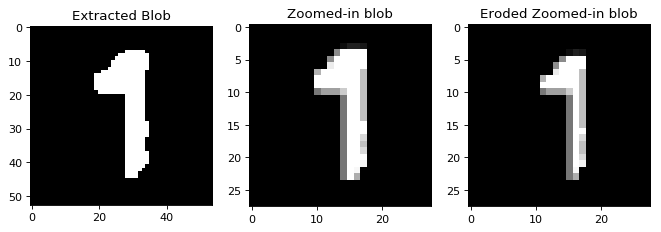

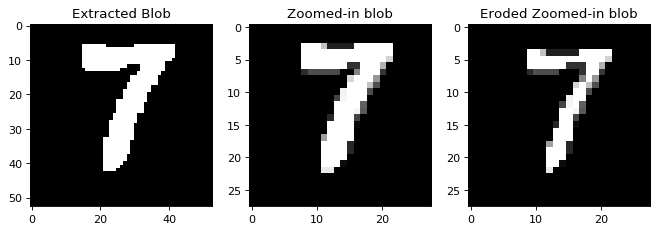

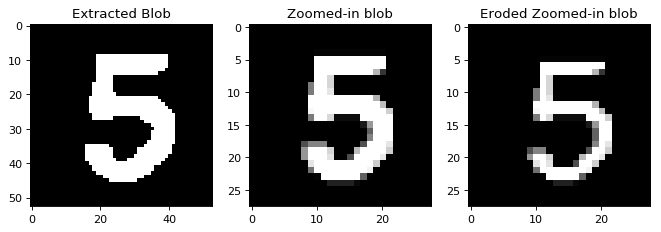

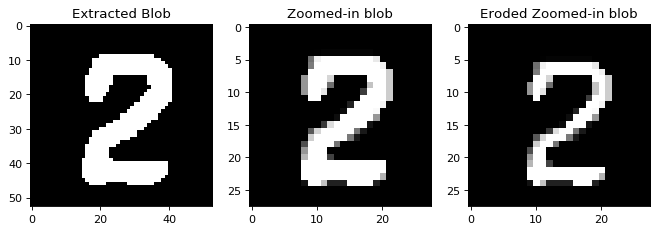

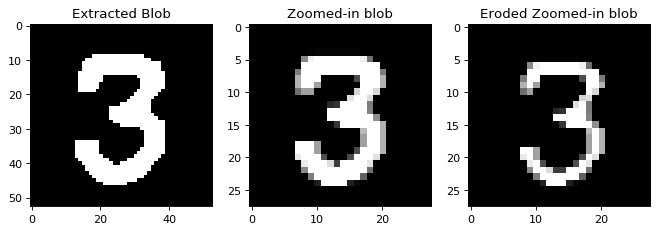

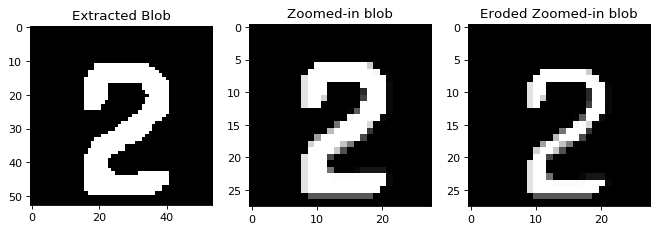

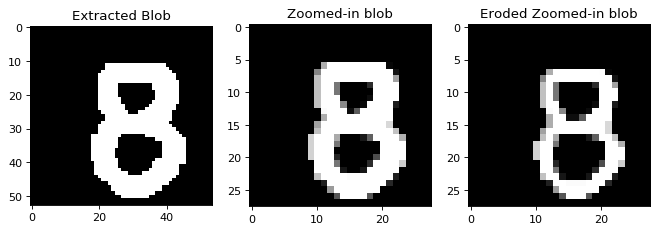

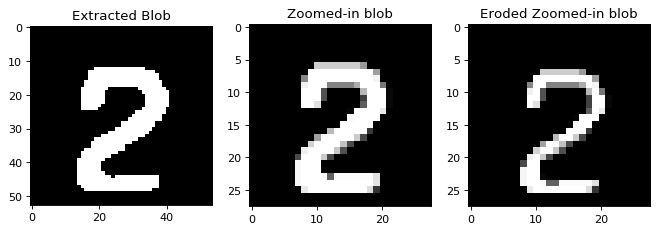

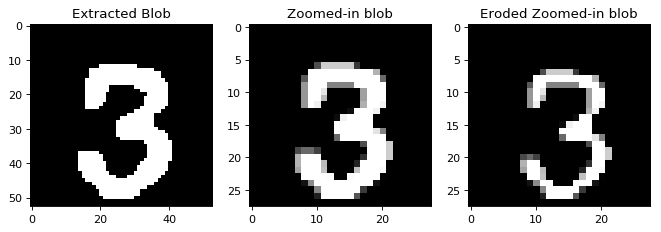

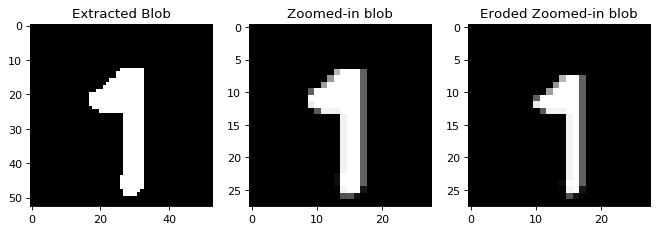

0 0 0 6 0 4 2 0 0 
7 0 6 0 0 0 0 0 3 
0 0 0 0 0 5 0 6 0 
0 2 0 0 2 0 0 3 2 
0 0 0 0 0 0 0 0 0 
4 3 0 0 7 0 0 1 0 
0 5 0 2 0 0 0 0 0 
3 0 0 0 0 0 2 0 8 
0 0 2 3 0 9 0 0 0 


In [191]:
#Display the underlying matrix
plt.imshow(overlay_opened, 'gray')
plt.show()

#Sudoku Matrix
mat = np.zeros((9,9), dtype=np.int)
r,c = overlay_opened.shape

#Divide into equal sized cells
x_steps = r/9
y_steps = c/9

#To Remove white regions around the edges
bias = 2

#Extract the digits
for i in range(9):
    x1 = int(i*x_steps)+bias
    x2 = int((i+1)*x_steps)-bias
    for j in range(9):
        y1 = int(j*y_steps)+bias
        y2 = int((j+1)*y_steps)-bias
        block = overlay_opened[x1:x2, y1:y2]
        
        if is_empty(block):
            mat[i,j] = 0
        else:
            digit, size = largest_CC(block)
            
#             roi, im = extract_digit(digit)
            roi = cv.resize(digit, (28,28))
            kernel = cv.getStructuringElement(cv.MORPH_RECT,(2,2));
            eroded_roi = cv.morphologyEx(roi, cv.MORPH_ERODE, kernel);

            # Classify each blob (NN)
            predictions = model.predict(np.array([np.expand_dims(roi, axis=2)/255.0]))
            mat[i,j] = np.argmax(predictions)
            # Classify each blob (linearSVM)
#             roi_hog_fd = hog(roi, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
#             nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
#             mat[i,j] = nbr

            fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
            plt.subplot(131); plt.imshow(digit, 'gray'); plt.title('Extracted Blob')
            plt.subplot(132); plt.imshow(roi, 'gray'); plt.title('Zoomed-in blob')
            plt.subplot(133); plt.imshow(eroded_roi, 'gray'); plt.title('Eroded Zoomed-in blob')
            plt.show()


display_matrix(mat)

### Solving the sudoku puzzle (Backtracking Algo)

In [117]:
#Solving the sudoku
def findNextCellToFill(grid, i, j):
    for x in range(i,9):
            for y in range(j,9):
                    if grid[x][y] == 0:
                            return x,y
    for x in range(0,9):
            for y in range(0,9):
                    if grid[x][y] == 0:
                            return x,y
    return -1,-1

def isValid(grid, i, j, e):
    rowOk = all([e != grid[i][x] for x in range(9)])
    if rowOk:
            columnOk = all([e != grid[x][j] for x in range(9)])
            if columnOk:
                    # finding the top left x,y co-ordinates of the section containing the i,j cell
                    secTopX, secTopY = 3 *(i//3), 3 *(j//3) #floored quotient should be used here. 
                    for x in range(secTopX, secTopX+3):
                            for y in range(secTopY, secTopY+3):
                                    if grid[x][y] == e:
                                            return False
                    return True
    return False

def solveSudoku(grid, i=0, j=0):
    i,j = findNextCellToFill(grid, i, j)
    if i == -1:
            return True
    for e in range(1,10):
            if isValid(grid,i,j,e):
                    grid[i][j] = e
                    if solveSudoku(grid, i, j):
                            return True
                    # Undo the current cell for backtracking
                    grid[i][j] = 0
    return False

#Test matrix
# mat = [[5,1,7,6,0,0,0,3,4],[2,8,9,0,0,4,0,0,0],[3,4,6,2,0,5,0,9,0],
#                  [6,0,2,0,0,0,0,1,0],[0,3,8,0,0,6,0,4,7],[0,0,0,0,0,0,0,0,0],[0,9,0,0,0,0,0,7,8],
#                  [7,0,3,4,0,0,5,6,0],[0,0,0,0,0,0,0,0,0]];

#Calling the function
display_matrix(mat)
print()
solveSudoku(mat)
display_matrix(mat)


5 1 7 6 0 0 0 3 4 
2 8 9 0 0 4 0 0 0 
3 4 6 2 0 5 0 9 0 
6 0 2 0 0 0 0 1 0 
0 3 8 0 0 6 0 4 7 
0 0 0 0 0 0 0 0 0 
0 9 0 0 0 0 0 7 8 
7 0 3 4 0 0 5 6 0 
0 0 0 0 0 0 0 0 0 

5 1 7 6 9 8 2 3 4 
2 8 9 1 3 4 7 5 6 
3 4 6 2 7 5 8 9 1 
6 7 2 8 4 9 3 1 5 
1 3 8 5 2 6 9 4 7 
9 5 4 7 1 3 6 8 2 
4 9 5 3 6 2 1 7 8 
7 2 3 4 8 1 5 6 9 
8 6 1 9 5 7 4 2 3 


### Overlaying the solution

In [ ]:
#Preparing a grid
r,c = sudoku_bw.shape
overlay_mat = np.zeros((r,c,3))

sudoku = cv.warpPerspective(img, backward, (rows,cols))

final_img = img.copy()

overlayLineSegments()

#Overlaying


fig=plt.figure(figsize=(20, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121); plt.imshow(img, 'gray'); plt.title('Original Image')
plt.subplot(122); plt.imshow(final_img, 'gray'); plt.title('Solution Overlaid Image')
# plt.subplot(233); plt.imshow(overlay, 'gray'); plt.title('Overlaid Outer Grid')
# plt.subplot(234); plt.imshow(overlay_opened, 'gray'); plt.title('Overlaid Opened')
plt.show()

### Real Time Rendering

In [ ]:
cap = cv.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    # Our operations on the frame come here
    
    frame1 = cv.flip(frame,0)
    
    # Display the resulting frame
    cv.imshow('frame',frame)   #frame is the captured image
    cv.imshow('frame1',frame1)
    if cv.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, 1se the capture
cap.release()
cv.destroyAllWindows()

In [ ]:
d=0
print(x_test.shape)
plt.imshow(x_test[d,:,:], 'gray')
plt.show()

In [ ]:
# Import the modules
from sklearn.externals import joblib
from skimage.feature import hog

mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# Load the classifier
clf = joblib.load("digits_cls.pkl")

img = x_test[4]

# Calculate the HOG features
roi_hog_fd = hog(img, orientations=9, pixels_per_cell=(14, 14), cells_per_block=(1, 1), visualise=False)
nbr = clf.predict(np.array([roi_hog_fd], 'float64'))
print(nbr)